In [6]:

import pandas as pd
# Load the CSV file into a pandas DataFrame
file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/output_csv/calls_total.csv'  # Replace this with your file path 
df_calls_total= pd.read_csv(file_path)

# Display the first few rows to verify
df_calls_total.head()

#NAN VALUE TREATMENT------------------------------------------------------------------
# Display the number of NaN values in each column
df_calls_total.isna().sum()

#Interpolate
df_converted = df_calls_total.convert_dtypes()

# Select only numeric columns for interpolation
numeric_cols = df_converted.select_dtypes(include=['number']).columns

# Perform interpolation on numeric columns only
df_converted[numeric_cols] = df_converted[numeric_cols].interpolate()

# Check for any remaining NaN values
df_converted.isna().sum()

#Backward Fill
df_bfill = df_converted.bfill()
df_bfill.isna().sum()

#Forward Fill
df_ffill = df_bfill.ffill()
df_ffill.isna().sum()

#creating a final df
final_df = df_ffill
final_df.head()

#optional
#final_df.to_csv('C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv', index=False)

# Check data types(optional)
#print(final_df.dtypes)

#summary statistics(optional)
#final_df.describe()



,Time,Value,exported_instance,exported_job,http_method,http_route,http_status_code,instance,job,service_name,span_kind,span_name,status_code
0,2024-08-22 07:36:45,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
1,2024-08-22 07:37:00,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
2,2024-08-22 07:37:15,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
3,2024-08-22 07:37:30,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET
4,2024-08-22 07:37:45,0.0,4e7184d9-e546-45dc-bed1-15904d41e452,express,GET,/,200.0,otel-collector:8889,aggregated-trace-metrics,express,SPAN_KIND_SERVER,GET /,STATUS_CODE_UNSET


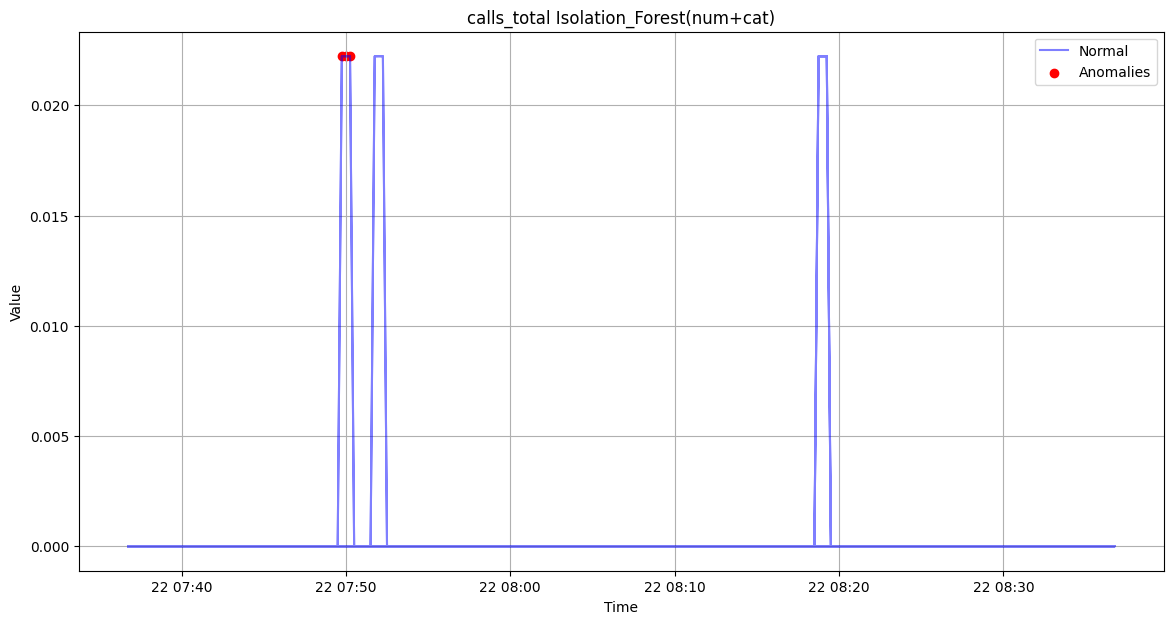

Number of anomalies detected: 3
                     Time     Value                     exported_instance  \
15958 2024-08-22 07:49:45  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   
15959 2024-08-22 07:50:00  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   
15960 2024-08-22 07:50:15  0.022223  4e7184d9-e546-45dc-bed1-15904d41e452   

      exported_job http_method http_route  http_status_code  \
15958  spring-boot     CONNECT          /             501.0   
15959  spring-boot     CONNECT          /             501.0   
15960  spring-boot     CONNECT          /             501.0   

                  instance                       job service_name  \
15958  otel-collector:8889  aggregated-trace-metrics  spring-boot   
15959  otel-collector:8889  aggregated-trace-metrics  spring-boot   
15960  otel-collector:8889  aggregated-trace-metrics  spring-boot   

              span_kind span_name        status_code  anomaly  
15958  SPAN_KIND_SERVER   CONNECT  STATUS_CODE_ERROR       -1  
1

In [54]:
#model with numerical and categorical anomalies (isolation_forest)

#DATA PROCESSING-----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest

# Selecting the numerical and categorical columns
numerical_columns = ['Value', 'http_status_code']
categorical_columns = ['exported_instance', 'exported_job', 'http_method', 
                       'http_route', 'instance', 'job', 'service_name', 
                       'span_kind', 'span_name', 'status_code']

# Preprocessing: Scaling numerical data and encoding categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)])

# Creating the Isolation Forest model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', IsolationForest(contamination=0.001, random_state=42))])

# Fit the model
model.fit(final_df)

# Predict anomalies (anomalies will be labeled as -1, normal as 1)
final_df['anomaly'] = model.fit_predict(final_df)

# Filter the anomalies
anomalies = final_df[final_df['anomaly'] == -1]

# Display the detected anomalies
anomalies

# PLOT THE ANOMALY
import matplotlib.pyplot as plt

# Convert 'Time' to datetime format
final_df['Time'] = pd.to_datetime(final_df['Time'])

# Plotting the time series data with anomalies
plt.figure(figsize=(14, 7))

# Plot all data points
plt.plot(final_df['Time'], final_df['Value'], label='Normal', color='blue', alpha=0.5)

# Highlight the anomalies
anomalies = final_df[final_df['anomaly'] == -1]
plt.scatter(anomalies['Time'], anomalies['Value'], color='red', label='Anomalies')

# Adding labels and title
plt.title('calls_total Isolation_Forest(num+cat)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.grid(True)
plt.show()
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())

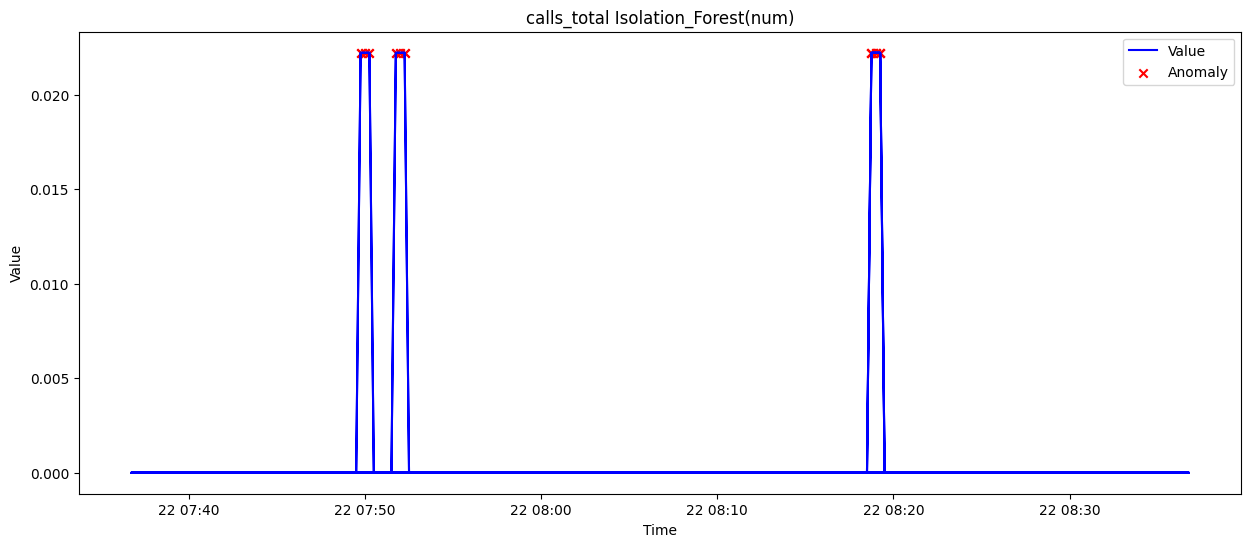

Number of anomalies detected: 21
                        Value                     exported_instance  \
Time                                                                  
2024-08-22 08:18:45  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   
2024-08-22 08:19:00  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   
2024-08-22 08:19:15  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   
2024-08-22 08:18:45  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   
2024-08-22 08:19:00  0.022222  4e7184d9-e546-45dc-bed1-15904d41e452   

                    exported_job http_method     http_route  http_status_code  \
Time                                                                            
2024-08-22 08:18:45      fastapi         GET              /             200.0   
2024-08-22 08:19:00      fastapi         GET              /             200.0   
2024-08-22 08:19:15      fastapi         GET              /             200.0   
2024-08-22 08:18:45      fastapi         GET  /testfunction     

In [55]:
#model with only numerical anomalies (isolation_forest)

# Convert 'Time' column to datetime and set as index
final_df['Time'] = pd.to_datetime(final_df['Time'])
final_df.set_index('Time', inplace=True)
 
# Select all relevant numeric metric columns for anomaly detection
metrics_columns = ['Value']  # Add other metric columns as needed
metrics_data = final_df[metrics_columns]
 
# Standardize the data
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_data)
 
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
 
# Fit the model and predict anomalies (-1 means anomaly, 1 means normal)
final_df['anomaly'] = iso_forest.fit_predict(metrics_scaled)
 
# Visualize the anomalies for each metric
for column in metrics_columns:
    plt.figure(figsize=(15, 6))
    plt.plot(final_df.index, final_df[column], label=column, color='blue')
    plt.scatter(final_df.index[final_df['anomaly'] == -1], final_df[column][final_df['anomaly'] == -1],
                color='red', label='Anomaly', marker='x')
    plt.title(f'calls_total Isolation_Forest(num)')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()
 
# Print out the anomalies
anomalies = final_df[final_df['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")
print(anomalies.head())

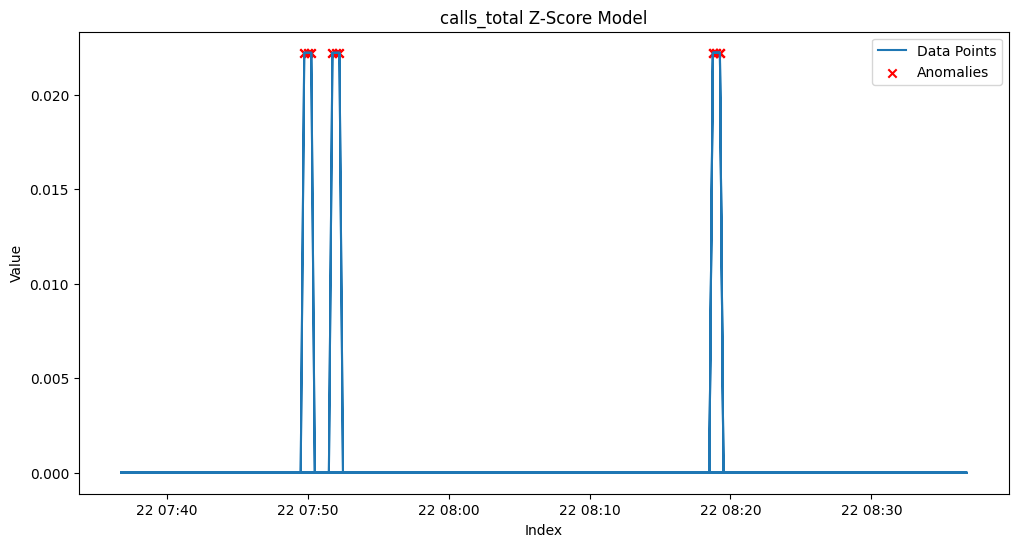

Number of anomalies detected: 21


In [56]:
#Z-Score 
import pandas as pd
from scipy.stats import zscore

# Load your DataFrame (df) here
# df = pd.read_csv('your_file.csv')

# Compute z-scores for the "Value" column
final_df['Value_zscore'] = zscore(final_df['Value'])

# Set a threshold for anomaly detection (e.g., 3 standard deviations)
threshold =0.1

# Flag anomalies (True for anomalies, False otherwise)
final_df['Anomaly'] = (final_df['Value_zscore'].abs() > threshold)

# Display the rows with anomalies
anomalies = final_df[final_df['Anomaly']]

# Print anomalies or handle them as needed
#print(anomalies)

import matplotlib.pyplot as plt

# Set the anomaly detection threshold
#threshold = 1

# Flag anomalies (True for anomalies, False otherwise)
final_df['Anomaly'] = (final_df['Value_zscore'].abs() > threshold)

# Plotting the data points and highlighting anomalies
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Data Points')
plt.scatter(final_df[final_df['Anomaly']].index, final_df[final_df['Anomaly']]['Value'], color='red', label='Anomalies', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('calls_total Z-Score Model')
plt.legend()
plt.show()
print(f"Number of anomalies detected: {len(anomalies)}")



Number of anomalies detected: 21


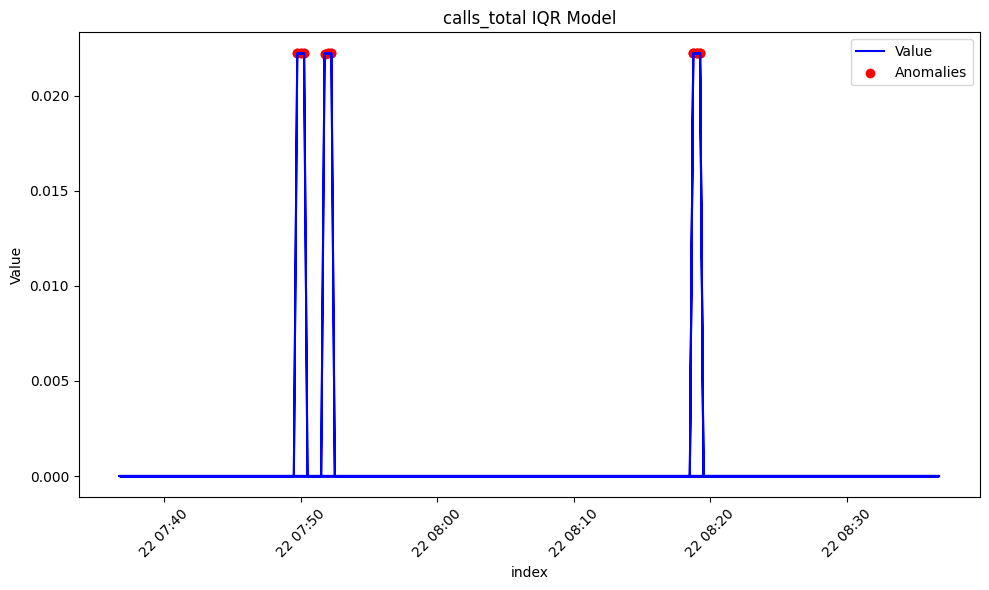

In [57]:
#IQR

import matplotlib.pyplot as plt

# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for the 'Value' column
Q1 = final_df['Value'].quantile(0.25)
Q3 = final_df['Value'].quantile(0.75)

# Step 2: Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Step 3: Define the lower and upper bounds for anomalies
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify anomalies
anomalies = final_df[(final_df['Value'] < lower_bound) | (final_df['Value'] > upper_bound)]

print(f"Number of anomalies detected: {len(anomalies)}")

# Step 5: Plotting the graph without converting 'Time' to datetime
plt.figure(figsize=(10, 6))

# Plot all values
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue')

# Highlight anomalies
plt.scatter(final_df[final_df['Anomaly']].index, final_df[final_df['Anomaly']]['Value'], color='red', label='Anomalies')

# Adding titles and labels
plt.title('calls_total IQR Model')
plt.xlabel('index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()



Number of anomalies detected: 4


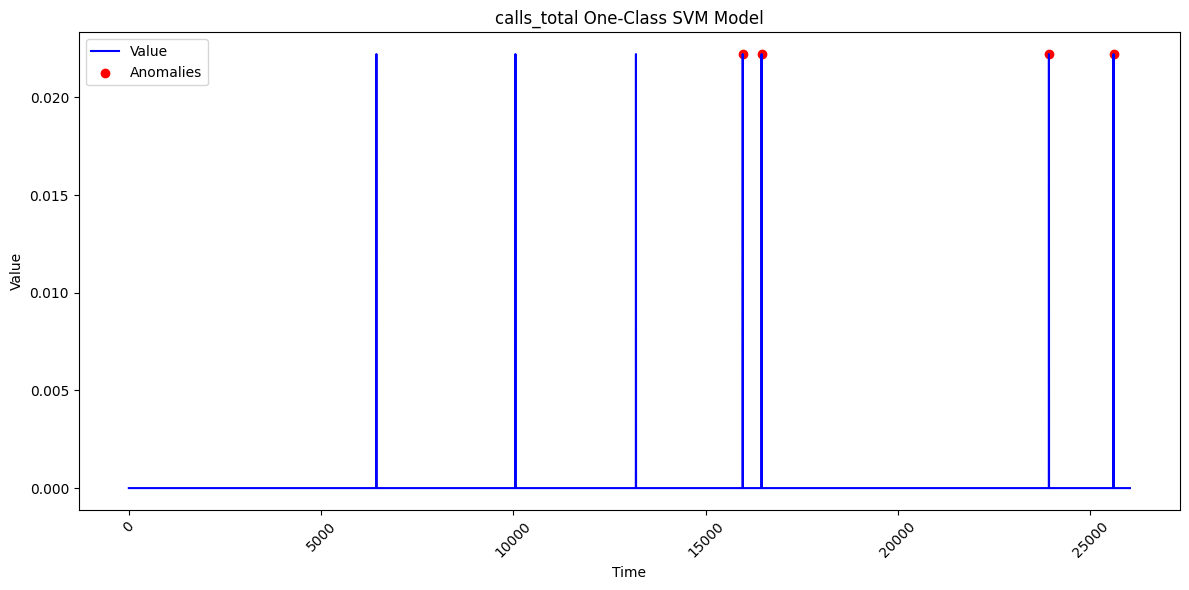

In [83]:
#One-Class SVM Model

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv'
# final_df = pd.read_csv(file_path)

# Strip any leading/trailing spaces from column names
final_df.columns = final_df.columns.str.strip()

# Select the numerical feature for One-Class SVM (e.g., 'Value')
X = final_df[['Value']]

# Standardize the feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.0001)  # You can adjust the parameters based on your needs
ocsvm.fit(X_scaled)

# Predict anomalies (1 for normal, -1 for anomaly)
final_df['anomaly'] = ocsvm.predict(X_scaled)

# Display the first few rows with the anomaly column
final_df[['Time', 'Value', 'anomaly']].head()

# Convert the 'Time' column to datetime format if not already
# final_df['Time'] = pd.to_datetime(final_df['Time'])

# Plot the values over time
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue')

# Highlight anomalies
anomalies = final_df[final_df['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies')

print(f"Number of anomalies detected: {len(anomalies)}")

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('calls_total One-Class SVM Model')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


                  Time  Value  LOF_Score  Outlier
0  2024-08-22 07:36:45    0.0          1    False
1  2024-08-22 07:37:00    0.0          1    False
2  2024-08-22 07:37:15    0.0          1    False
3  2024-08-22 07:37:30    0.0          1    False
4  2024-08-22 07:37:45    0.0          1    False
Number of anomalies detected: 17


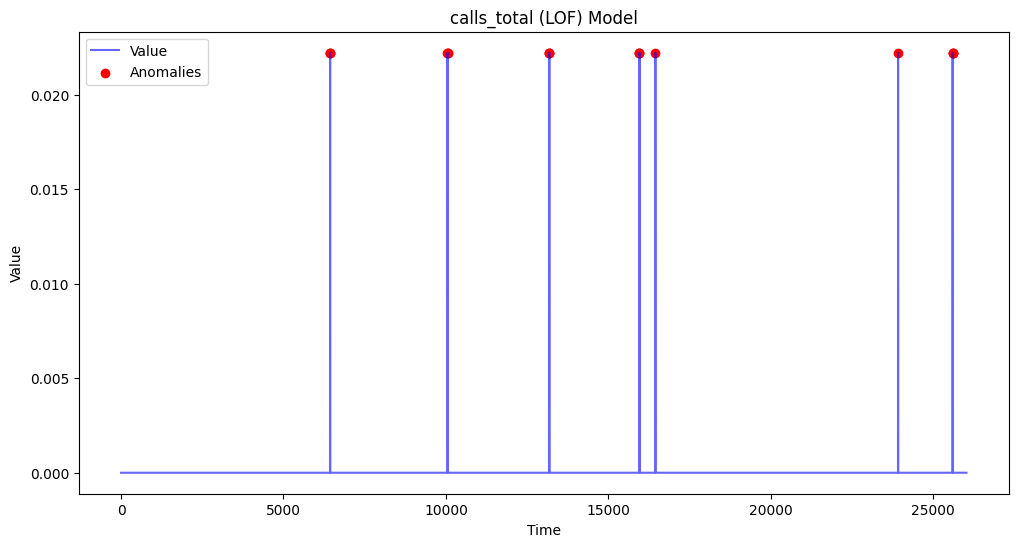

In [82]:
# LOF Model

from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Load the dataset
#df = pd.read_csv('your_dataset.csv')  # Use the correct path to your CSV

# Extract the 'Value' column for LOF analysis
X = final_df[['Value']].values

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed
final_df['LOF_Score'] = lof.fit_predict(X)

# Add a column to indicate if a point is an outlier (-1) or not (1)
final_df['Outlier'] = final_df['LOF_Score'] == -1

# Display the dataframe with LOF scores and outlier labels
print(final_df[['Time', 'Value', 'LOF_Score', 'Outlier']].head())

import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['Value'], label='Value', color='blue',  alpha=0.6)

# Highlight anomalies
anomalies = final_df[final_df['Outlier'] == True]
plt.scatter(anomalies.index, anomalies['Value'], color='red', label='Anomalies')

print(f"Number of anomalies detected: {len(anomalies)}")

# Adding labels and title
plt.title('calls_total (LOF) Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show plot
plt.show()

C:\Users\abhis\AppData\Local\Temp\ipykernel_19636\311083165.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df['Value'].resample('5T').sum()


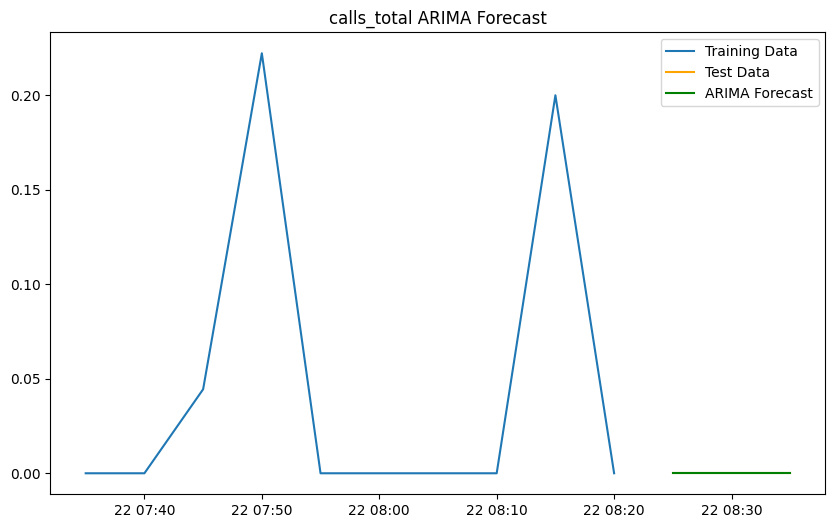

In [116]:
#ARIMA Model

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv'
df = pd.read_csv(file_path)

# Step 2: Parse the 'Time' column as datetime and set it as the index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Step 3: Resample the data by summing the 'Value' column every 15 minutes to handle any irregular intervals
df_resampled = df['Value'].resample('5T').sum()

# Step 4: Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]

# Step 5: Fit the ARIMA model on the training data
# We'll use a basic ARIMA model with (p, d, q) = (1, 1, 1) as a starting point.
model = ARIMA(train, order=(0, 1, 0))
arima_result = model.fit()

# Step 6: Forecast on the test data
forecast = arima_result.forecast(steps=len(test))

# Step 7: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.legend()
plt.title('calls_total ARIMA Forecast')
plt.show()


In [ ]:
#Prophet Model [Module not found error]

import pandas as pd
import Prophet
import matplotlib.pyplot as plt

# Load your dataset
#df = pd.read_csv('C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv')
final_df = df

# Rename columns to fit Prophet's requirements
df.rename(columns={'Time': 'ds', 'Value': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df[['ds', 'y']])

# Make a future dataframe for prediction (let's predict 100 steps ahead)
future = model.make_future_dataframe(periods=100, freq='15s')  # Assuming 15-second intervals in the data
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# Add anomaly detection (optional)
df['yhat'] = forecast['yhat'][:len(df)]
df['yhat_upper'] = forecast['yhat_upper'][:len(df)]
df['yhat_lower'] = forecast['yhat_lower'][:len(df)]

# Anomalies are when the actual value falls outside the prediction interval
anomalies = df[(df['y'] > df['yhat_upper']) | (df['y'] < df['yhat_lower'])]

# Plot anomalies
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.legend()

# Show the plot
plt.show()


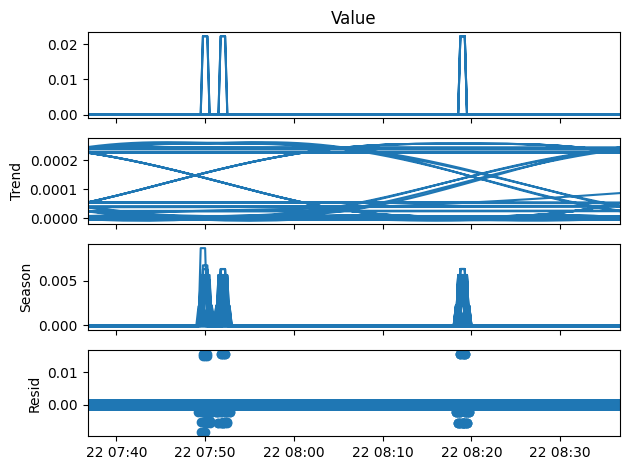

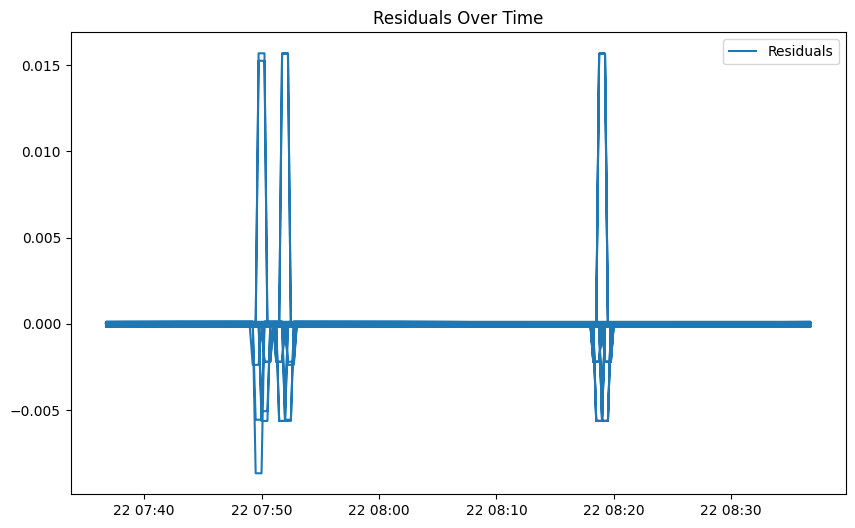

In [1]:
#Seasonal Decomposition of Time Series (STL)

import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the dataset
file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv'  # Update this path as needed
df = pd.read_csv(file_path)

# Convert 'Time' column to datetime and set it as the index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Assuming data points are collected every 15 seconds in a 1-hour period
period = 240  # 4 data points per minute * 60 minutes = 240 data points per hour

# Perform STL decomposition with the specified period
stl = STL(df['Value'], period=period)
result = stl.fit()

# Plot the decomposed components
result.plot()
plt.show()

# Extract residuals from STL decomposition
residuals = result.resid

# 1. Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

# 2. Histogram and KDE plot of residuals
# plt.figure(figsize=(10, 6))
# sns.histplot(residuals, kde=True, stat="density", linewidth=0)
# plt.title('Histogram and KDE of Residuals')
# plt.show()

# 3. ACF and PACF plots of residuals
# plt.figure(figsize=(10, 6))
# plot_acf(residuals.dropna(), lags=40)
# plt.title('Autocorrelation Function (ACF) of Residuals')
# plt.show()

# plt.figure(figsize=(10, 6))
# plot_pacf(residuals.dropna(), lags=40)
# plt.title('Partial Autocorrelation Function (PACF) of Residuals')
# plt.show()

# 4. Perform Augmented Dickey-Fuller test for stationarity
# adf_result = adfuller(residuals.dropna())

# Extracting and displaying ADF test results
# adf_output = {
#     'ADF Statistic': adf_result[0],
#     'p-value': adf_result[1],
#     'Number of Lags Used': adf_result[2],
#     'Number of Observations Used': adf_result[3]
# }

# adf_output



In [ ]:
#LSTM Model[Array method error]

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split

# Load the data
file_path = 'C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv'
df = pd.read_csv(file_path)

# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Sort by time (just to ensure correct order)
df = df.sort_values(by='Time')

# Extract the 'Value' column for modeling
values = df['Value'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Parameters
SEQ_LENGTH = 10  # Sequence length (this can be tuned)

# Create sequences
X, y = create_sequences(values_scaled, SEQ_LENGTH)

# Reshape X to be compatible with LSTM (samples, time steps, features)
X = np.array(X).reshape((X.shape[0], X.shape[1], 1))

# Ensure y is also a numpy array
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model with Input layer
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, 1)))  # Use Input layer to define the shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get them back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print a few predictions and actual values
print("Predictions:", predictions_rescaled[:5].flatten())
print("Actual Values:", y_test_rescaled[:5].flatten())


In [ ]:
#Autoencoder Model[check google collab folder for results]

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import layers, models

# Load your data
df = pd.read_csv('C:/Users/abhis/Desktop/CloudBuilders/Grafana-Anomaly/Grafana-Anomaly_Detection/Anomaly_grafana/dataframes/calls_total_df.csv')

# Preprocessing
numerical_features = ['Value']
categorical_features = ['http_method', 'http_route', 'http_status_code']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X = df[numerical_features + categorical_features]
X_preprocessed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test = train_test_split(X_preprocessed, test_size=0.2, random_state=42)

# Convert sparse to dense arrays if needed
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Autoencoder model
input_dim = X_train_dense.shape[1]
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(X_train_dense, X_train_dense,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_dense, X_test_dense))
